<a href="https://colab.research.google.com/github/soliman787/Soft-Computing/blob/main/Copy_of_Soft_Computing_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df_raw = pd.read_csv('/content/crimedata.csv')

df_raw.head()


,communityName,state,countyCode,communityCode,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,11980,3.10,1.37,91.78,6.50,1.88,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,23123,2.82,0.80,95.57,3.44,0.85,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,29344,2.43,0.74,94.33,3.43,2.35,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,16656,2.40,1.70,97.35,0.50,0.70,...,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,Bemidjicity,MN,7.0,5068.0,11245,2.76,0.53,89.16,1.17,0.52,...,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79


In [ ]:
df_raw.info()
df_raw.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 146 entries, communityName to nonViolPerPop
dtypes: float64(116), int64(28), object(2)
memory usage: 2.5+ MB


,0
communityName,object
state,object
countyCode,float64
communityCode,float64
population,int64
...,...
autoTheftPerPop,float64
arsons,float64
arsonsPerPop,float64
ViolentCrimesPerPop,float64


In [ ]:
!pip install deap
!pip install pyswarms

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from deap import base, creator, tools, algorithms

import pyswarms as ps

import matplotlib.pyplot as plt
import seaborn as sns
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.2 MB/s eta 0:00:00


**Data Preprocessing**

In [ ]:
# Data Preprocessing
print("\n--- Data Preprocessing ---")


if 'ViolentCrimesPerPop' not in df_raw.columns:
    print("ERROR: 'ViolentCrimesPerPop' column not found. Please check column names.")

    if df_raw.shape[1] > 5:
        target_col_name = df_raw.columns[-1]
        print(f"Assuming '{target_col_name}' is the target variable based on position.")
        if df_raw[target_col_name].isnull().all():
             print(f"Target column {target_col_name} is all NaNs. Cannot proceed with it as target.")

             numeric_cols_for_target = df_raw.select_dtypes(include=np.number).columns
             if len(numeric_cols_for_target) > 0:
                 target_col_name = numeric_cols_for_target[0] # Take the first numeric one
                 print(f"WARNING: Using '{target_col_name}' as a fallback target. THIS IS LIKELY WRONG. Please verify.")
             else:
                 print("FATAL: No suitable numeric target column found. Please inspect your data.")
                 exit()
    else:
        print("FATAL: Cannot automatically determine target. Please inspect data.")
        exit()
else:
    target_col_name = 'ViolentCrimesPerPop'

df_raw.dropna(subset=[target_col_name], inplace=True)
print(f"Shape after dropping rows with missing target ({target_col_name}): {df_raw.shape}")

if df_raw.empty:
    print(f"FATAL: No data left after dropping NaNs in target column '{target_col_name}'. Check data quality.")
    exit()

median_crime = df_raw[target_col_name].median()
df_raw['crime_category'] = (df_raw[target_col_name] > median_crime).astype(int)
y = df_raw['crime_category']



--- Data Preprocessing ---
Shape after dropping rows with missing target (ViolentCrimesPerPop): (1994, 146)


In [ ]:
# 2. Select features (X) - drop original target, new categorical target, and non-predictive columns

cols_to_drop = [target_col_name, 'crime_category', 'communityname', 'state', 'county', 'community', 'fold']
cols_to_drop_existing = [col for col in cols_to_drop if col in df_raw.columns]
X = df_raw.drop(columns=cols_to_drop_existing)
print(f"Features selected. Shape of X: {X.shape}")

Features selected. Shape of X: (1994, 144)


In [ ]:
# 3. Handle missing values in features (X) using median imputation



for col in X.columns:
    if X[col].dtype == 'object':
        try:
            X[col] = pd.to_numeric(X[col])
        except ValueError:
            print(f"Could not convert column {col} to numeric. It might contain non-numeric strings other than '?'. Dropping it.")
            X.drop(columns=[col], inplace=True)

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

print("Missing values handled. Shape of X after imputation:", X.shape)
if X.empty or X.shape[1] == 0:
    print("FATAL: No features remaining after preprocessing. Check data and column drop logic.")
    exit()

# 4. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 5. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to preserve column names for feature selection steps
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)


print(f"Data split and scaled. X_train shape: {X_train_scaled_df.shape}, X_test shape: {X_test_scaled_df.shape}")

# Store results
results = {}



Could not convert column communityName to numeric. It might contain non-numeric strings other than '?'. Dropping it.
Missing values handled. Shape of X after imputation: (1994, 143)
Data split and scaled. X_train shape: (1395, 143), X_test shape: (599, 143)


In [ ]:
# Helper function to evaluate model
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    # print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

**Using original dataset with all available features**

In [ ]:
# Scenario 1 - Using original dataset with all available features

print("\n--- Scenario 1: Model with All Features ---")
model_all_features = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_all_features.fit(X_train_scaled_df, y_train)
y_pred_all = model_all_features.predict(X_test_scaled_df)
results['All Features'] = evaluate_model(y_test, y_pred_all, "Random Forest (All Features)")

# Identify most influential features from the full model
importances_all = model_all_features.feature_importances_
feature_names_all = X.columns
feature_importance_df_all = pd.DataFrame({'feature': feature_names_all, 'importance': importances_all})
feature_importance_df_all = feature_importance_df_all.sort_values(by='importance', ascending=False)
print("\nTop 10 features (All Features Model):")
print(feature_importance_df_all.head(10))


--- Scenario 1: Model with All Features ---

--- Random Forest (All Features) ---
Accuracy: 0.9449
Precision: 0.9460
Recall: 0.9449
F1-Score: 0.9449

Top 10 features (All Features Model):
                 feature  importance
133        assaultPerPop    0.133408
132             assaults    0.108616
131          robbbPerPop    0.057302
135          burglPerPop    0.051671
130            robberies    0.039397
142        nonViolPerPop    0.036664
46           PctKids2Par    0.030462
5           racePctWhite    0.030460
52   PctKidsBornNeverMar    0.028845
134           burglaries    0.023538


**Feature Selection with Genetic Algorithm (GA)**

In [ ]:
print("\n--- Scenario 2: Feature Selection with Genetic Algorithm (GA) ---")

# GA Parameters
N_POPULATION = 30  # Number of individuals in population
N_GENERATIONS = 20 # Number of generations
CXPB = 0.6         # Crossover probability
MUTPB = 0.2        # Mutation probability
N_FEATURES = X_train_scaled_df.shape[1]

# Define Fitness: We want to maximize F1-score
# The fitness value must be a tuple, so we return (f1_score,)
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Maximize F1
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
# Attribute generator: 0 or 1 (for feature selection)
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, N_FEATURES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)



--- Scenario 2: Feature Selection with Genetic Algorithm (GA) ---


In [ ]:
# Evaluation function for GA
def evalFeatures(individual):
    selected_feature_indices = [i for i, bit in enumerate(individual) if bit == 1]
    if not selected_feature_indices: # No features selected
        return 0, # Return a tuple

    # Select features based on the individual
    X_train_subset = X_train_scaled_df.iloc[:, selected_feature_indices]
    X_test_subset = X_test_scaled_df.iloc[:, selected_feature_indices]

    model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', n_jobs=-1) # Smaller estimator for faster GA
    model.fit(X_train_subset, y_train)
    y_pred = model.predict(X_test_subset)
    return f1_score(y_test, y_pred, average='weighted', zero_division=0), # Return a tuple

toolbox.register("evaluate", evalFeatures)
toolbox.register("mate", tools.cxTwoPoint) # Crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) # Mutation
toolbox.register("select", tools.selTournament, tournsize=3) # Selection


In [ ]:
# Run GA
print(f"Running GA with {N_POPULATION} individuals for {N_GENERATIONS} generations...")
population = toolbox.population(n=N_POPULATION)
# To track best fitness over generations
logbook = tools.Logbook()
logbook.header = "gen", "evals", "avg", "min", "max"
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)


for gen in range(N_GENERATIONS):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    record = stats.compile(population)
    logbook.record(gen=gen, evals=len(offspring), **record)
    print(logbook.stream)


best_individual_ga = tools.selBest(population, k=1)[0]
selected_features_ga_indices = [i for i, bit in enumerate(best_individual_ga) if bit == 1]

if not selected_features_ga_indices:
    print("GA selected no features. This can happen. Using all features as a fallback for this scenario.")
    X_train_ga_selected = X_train_scaled_df
    X_test_ga_selected = X_test_scaled_df
    selected_feature_names_ga = X.columns.tolist()
else:
    selected_feature_names_ga = X.columns[selected_features_ga_indices].tolist()
    X_train_ga_selected = X_train_scaled_df.iloc[:, selected_features_ga_indices]
    X_test_ga_selected = X_test_scaled_df.iloc[:, selected_features_ga_indices]

print(f"\nGA selected {len(selected_feature_names_ga)} features: {selected_feature_names_ga[:10]}...") # Print first 10

Running GA with 30 individuals for 20 generations...
gen	evals	avg    	min     	max     
0  	30   	0.94718	0.883132	0.961599
1  	30   	0.95614	0.949914	0.961599
2  	30   	0.960372	0.954914	0.963265
3  	30   	0.961154	0.958257	0.963268
4  	30   	0.96132 	0.956589	0.96661 
5  	30   	0.963046	0.959921	0.96661 
6  	30   	0.963047	0.958257	0.96661 
7  	30   	0.963603	0.959921	0.966609
8  	30   	0.964827	0.961597	0.966609
9  	30   	0.966052	0.959925	0.966609
10 	30   	0.966609	0.966607	0.966609
11 	30   	0.966609	0.966609	0.966609
12 	30   	0.966331	0.958253	0.966609
13 	30   	0.966609	0.966609	0.966609
14 	30   	0.966609	0.966609	0.966609
15 	30   	0.966609	0.966609	0.966609
16 	30   	0.966832	0.966609	0.968279
17 	30   	0.966664	0.959921	0.969946
18 	30   	0.967555	0.961599	0.969946
19 	30   	0.967498	0.951568	0.969946

GA selected 64 features: ['countyCode', 'communityCode', 'householdsize', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf'

In [ ]:

# Train final model with GA selected features
model_ga = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_ga.fit(X_train_ga_selected, y_train)
y_pred_ga = model_ga.predict(X_test_ga_selected)
results['GA Selected'] = evaluate_model(y_test, y_pred_ga, "Random Forest (GA Selected Features)")

# Identify most influential features from the GA-selected set
if len(selected_feature_names_ga) > 0 and not X_train_ga_selected.empty :
    importances_ga = model_ga.feature_importances_
    feature_importance_df_ga = pd.DataFrame({'feature': selected_feature_names_ga, 'importance': importances_ga})
    feature_importance_df_ga = feature_importance_df_ga.sort_values(by='importance', ascending=False)
    print("\nTop 10 features (GA Selected Model):")
    print(feature_importance_df_ga.head(10))
else:
    print("No features selected by GA, or features dataframe is empty, skipping importance.")

del creator.FitnessMax
del creator.Individual


--- Random Forest (GA Selected Features) ---
Accuracy: 0.9649
Precision: 0.9654
Recall: 0.9649
F1-Score: 0.9649

Top 10 features (GA Selected Model):
                feature  importance
57        assaultPerPop    0.330954
56          robbbPerPop    0.089923
23  NumKidsBornNeverMar    0.066312
58          burglPerPop    0.059036
20           PctFam2Par    0.048454
24  PctKidsBornNeverMar    0.042914
3          racePctWhite    0.039427
55          rapesPerPop    0.023705
62      autoTheftPerPop    0.021748
54                rapes    0.016654


**Feature Selection with Particle Swarm Optimization (PSO)**

In [ ]:
print("\n--- Scenario 3: Feature Selection with Particle Swarm Optimization (PSO) ---")

# PSO Parameters
N_PARTICLES = 30
N_ITERATIONS = 20

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': N_PARTICLES // 2, 'p': 2}

# Fitness function for PSO (PySwarms expects a cost function, so we minimize 1 - F1_score)
def pso_fitness_func(swarm_particle_matrix):
    costs = []
    for particle_idx in range(swarm_particle_matrix.shape[0]):
        particle = swarm_particle_matrix[particle_idx, :]
        selected_feature_indices = np.where(particle == 1)[0]

        if len(selected_feature_indices) == 0:
            costs.append(1.0)
            continue

        X_train_subset = X_train_scaled_df.iloc[:, selected_feature_indices]
        X_test_subset = X_test_scaled_df.iloc[:, selected_feature_indices]

        model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', n_jobs=-1) # Smaller estimator
        model.fit(X_train_subset, y_train)
        y_pred = model.predict(X_test_subset)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        costs.append(1.0 - f1)
    return np.array(costs)



--- Scenario 3: Feature Selection with Particle Swarm Optimization (PSO) ---


In [ ]:
# Initialize BinaryPSO
optimizer = ps.discrete.BinaryPSO(n_particles=N_PARTICLES, dimensions=N_FEATURES, options=options)

# Perform optimization
print(f"Running PSO with {N_PARTICLES} particles for {N_ITERATIONS} iterations...")
cost, best_pos_pso = optimizer.optimize(pso_fitness_func, iters=N_ITERATIONS, verbose=True)

selected_features_pso_indices = np.where(best_pos_pso == 1)[0]

if len(selected_features_pso_indices) == 0:
    print("PSO selected no features. Using all features as a fallback.")
    X_train_pso_selected = X_train_scaled_df
    X_test_pso_selected = X_test_scaled_df
    selected_feature_names_pso = X.columns.tolist()
else:
    selected_feature_names_pso = X.columns[selected_features_pso_indices].tolist()
    X_train_pso_selected = X_train_scaled_df.iloc[:, selected_features_pso_indices]
    X_test_pso_selected = X_test_scaled_df.iloc[:, selected_features_pso_indices]

print(f"\nPSO selected {len(selected_feature_names_pso)} features: {selected_feature_names_pso[:10]}...")

model_pso = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_pso.fit(X_train_pso_selected, y_train)
y_pred_pso = model_pso.predict(X_test_pso_selected)
results['PSO Selected'] = evaluate_model(y_test, y_pred_pso, "Random Forest (PSO Selected Features)")

if len(selected_feature_names_pso) > 0 and not X_train_pso_selected.empty:
    importances_pso = model_pso.feature_importances_
    feature_importance_df_pso = pd.DataFrame({'feature': selected_feature_names_pso, 'importance': importances_pso})
    feature_importance_df_pso = feature_importance_df_pso.sort_values(by='importance', ascending=False)
    print("\nTop 10 features (PSO Selected Model):")
    print(feature_importance_df_pso.head(10))
else:
    print("No features selected by PSO, or features dataframe is empty, skipping importance.")

2025-05-15 21:55:07,033 - pyswarms.discrete.binary - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 15, 'p': 2}


Running PSO with 30 particles for 20 iterations...


pyswarms.discrete.binary: 100%|██████████|20/20, best_cost=0.0317
2025-05-15 21:59:08,832 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.031720593452540746, best pos: [0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1
 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0
 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0]



PSO selected 83 features: ['communityCode', 'population', 'racepctblack', 'racePctWhite', 'racePctAsian', 'agePct12t21', 'agePct16t24', 'agePct65up', 'numbUrban', 'medIncome']...

--- Random Forest (PSO Selected Features) ---
Accuracy: 0.9683
Precision: 0.9684
Recall: 0.9683
F1-Score: 0.9683

Top 10 features (PSO Selected Model):
            feature  importance
76    assaultPerPop    0.275553
75      robbbPerPop    0.090701
78      burglPerPop    0.073425
25      PctKids2Par    0.058678
74        robberies    0.050771
3      racePctWhite    0.050242
77       burglaries    0.037870
72            rapes    0.023430
81  autoTheftPerPop    0.020923
38   PctHousLess3BR    0.018802



--- Performance Summary ---
              accuracy  precision    recall        f1
All Features  0.944908   0.946023  0.944908  0.944871
GA Selected   0.964942   0.965360  0.964942  0.964933
PSO Selected  0.968280   0.968410  0.968280  0.968278


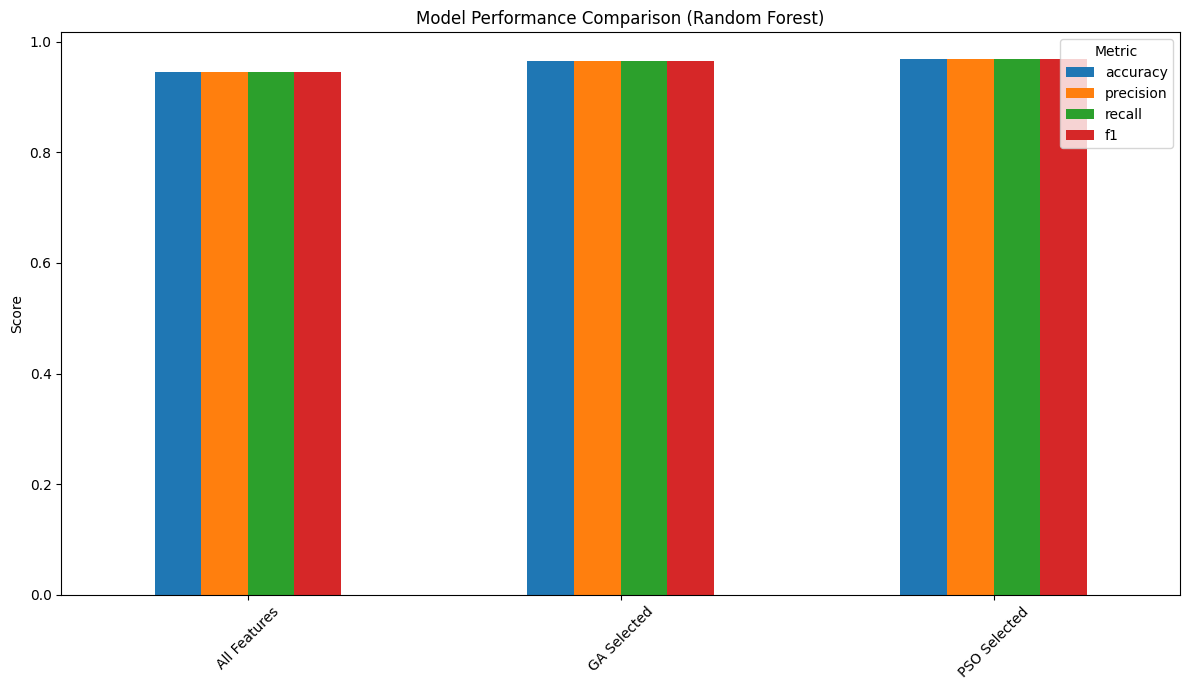

In [ ]:
# Summarize and Compare Performance

print("\n--- Performance Summary ---")
results_df = pd.DataFrame(results).T # Transpose for better readability
results_df = results_df[['accuracy', 'precision', 'recall', 'f1']] # Ensure order

print(results_df)

# Bar chart for comparison
results_df.plot(kind='bar', figsize=(12, 7))
plt.title('Model Performance Comparison (Random Forest)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('performance_comparison_chart.png') # Save the chart
plt.show()

In [ ]:

print("\n--- Project Documentation Placeholders ---")
print("\n1. ML Algorithm (Random Forest):")
print("   - Flowchart: [Conceptual: Data -> Bootstrap Samples -> Build Trees (Random Feature Subsets) -> Aggregate Votes -> Prediction]")
print("   - Pseudocode:")
print("     Algorithm RandomForest(TrainingSet D, NumberOfTrees B):")
print("       Initialize Forest F = {}")
print("       For b = 1 to B:")
print("         D_b = BootstrapSample(D)")
print("         T_b = BuildDecisionTree(D_b, random_feature_subset_at_each_split)")
print("         Add T_b to F")
print("       Return F")
print("     To predict for instance x:")
print("       Aggregate votes from all trees in F")
print("       Return class with majority vote")

print("\n2. GA Optimization Algorithm Process:")
print("   - Flowchart: [Conceptual: Initialize Population -> Evaluate Fitness -> Selection -> Crossover -> Mutation -> New Population -> Repeat until termination]")
print("   - Pseudocode (for feature selection):")
print("     Algorithm GeneticAlgorithmFeatureSelection(Features, Target, PopSize, Generations):")
print("       Initialize Population P with random binary strings (individuals)")
print("       For g = 1 to Generations:")
print("         For each individual I in P:")
print("           Fitness(I) = EvaluateMLModel(Features_selected_by_I, Target)")
print("         P_selected = SelectParents(P, Fitness_values)")
print("         P_offspring = Crossover(P_selected)")
print("         P_mutated = Mutate(P_offspring)")
print("         P = P_mutated (or combine with P_selected for elitism)")
print("       Return BestIndividual(P)")

print("\n3. PSO Optimization Algorithm Process:")
print("   - Flowchart: [Conceptual: Initialize Particles (positions, velocities) -> Evaluate Fitness -> Update Personal Best & Global Best -> Update Velocities -> Update Positions -> Repeat until termination]")
print("   - Pseudocode (for feature selection):")
print("     Algorithm PSOFeatureSelection(Features, Target, NumParticles, Iterations):")
print("       Initialize Particles (random binary positions, random velocities)")
print("       Initialize pBest_positions = current_positions, gBest_position = best_among_pBests")
print("       For iter = 1 to Iterations:")
print("         For each particle i:")
print("           Fitness(particle_i_position) = EvaluateMLModel(Features_selected_by_particle_i_position, Target)")
print("           If Fitness(particle_i_position) is better than Fitness(pBest_position_i):")
print("             pBest_position_i = particle_i_position")
print("           If Fitness(particle_i_position) is better than Fitness(gBest_position):")
print("             gBest_position = particle_i_position")
print("         For each particle i:")
print("           Update_velocity(particle_i, pBest_position_i, gBest_position)")
print("           Update_position(particle_i) // ensure binary for feature selection")
print("       Return gBest_position")



print("\n5. Block diagram of the implemented system:")
print("   [Raw CSV Data] -> [Preprocessing (Handle '?', Impute NaNs, Create Target, Scale)] -> ")
print("     |--> [Scenario 1: Train RF with All Features] --> [Evaluate Model 1]")
print("     |--> [Scenario 2: GA for Feature Selection] -> [Select GA Features] -> [Train RF with GA Features] --> [Evaluate Model 2]")
print("     |--> [Scenario 3: PSO for Feature Selection] -> [Select PSO Features] -> [Train RF with PSO Features] --> [Evaluate Model 3]")
print("     --> [Compare Metrics (Accuracy, Precision, Recall, F1) & Visualize]")



--- Project Documentation Placeholders ---

1. ML Algorithm (Random Forest):
   - Flowchart: [Conceptual: Data -> Bootstrap Samples -> Build Trees (Random Feature Subsets) -> Aggregate Votes -> Prediction]
   - Pseudocode:
     Algorithm RandomForest(TrainingSet D, NumberOfTrees B):
       Initialize Forest F = {}
       For b = 1 to B:
         D_b = BootstrapSample(D)
         T_b = BuildDecisionTree(D_b, random_feature_subset_at_each_split)
         Add T_b to F
       Return F
     To predict for instance x:
       Aggregate votes from all trees in F
       Return class with majority vote

2. GA Optimization Algorithm Process:
   - Flowchart: [Conceptual: Initialize Population -> Evaluate Fitness -> Selection -> Crossover -> Mutation -> New Population -> Repeat until termination]
   - Pseudocode (for feature selection):
     Algorithm GeneticAlgorithmFeatureSelection(Features, Target, PopSize, Generations):
       Initialize Population P with random binary strings (individuals)
  